# Import Necessary Libraries

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load Data

In [ ]:
# Load the dataset
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split Data

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# AdaBoost Implementation

In [ ]:
# Define the AdaBoost Classifier from scratch with enhancements
class AdaBoostClassifierEnhanced:
    def __init__(self, n_estimators=50, learning_rate=1.0, early_stopping_rounds=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.early_stopping_rounds = early_stopping_rounds
        self.models = []
        self.model_weights = []
        self.sample_weights = None
        self.error_rates = []

    def fit(self, X, y):
        n_samples = len(y)
        self.sample_weights = np.ones(n_samples) / n_samples

        best_error = float("inf")
        early_stop_count = 0

        for estimator in range(self.n_estimators):
            # Train a weak learner (decision stump)
            tree = DecisionTreeClassifier(max_depth=1)
            tree.fit(X, y, sample_weight=self.sample_weights)
            y_pred = tree.predict(X)

            # Compute weighted error
            incorrect = (y_pred != y)
            error = np.dot(self.sample_weights, incorrect) / sum(self.sample_weights)

            # Stop if error is 0
            if error == 0:
                self.models.append(tree)
                self.model_weights.append(1)
                break

            # Calculate model weight
            model_weight = self.learning_rate * 0.5 * np.log((1 - error) / (error + 1e-10))

            # Update sample weights
            self.sample_weights *= np.exp(-model_weight * y * 2 * (y_pred == y) + model_weight * 2 * incorrect)
            self.sample_weights /= np.sum(self.sample_weights)

            # Save model and model weight
            self.models.append(tree)
            self.model_weights.append(model_weight)
            self.error_rates.append(error)

            # Early stopping
            if error < best_error:
                best_error = error
                early_stop_count = 0
            else:
                early_stop_count += 1

            if self.early_stopping_rounds and early_stop_count >= self.early_stopping_rounds:
                print(f"Early stopping at iteration {estimator}")
                break

    def predict(self, X):
        # Combine predictions from all weak learners
        predictions = np.zeros(X.shape[0])
        for tree, model_weight in zip(self.models, self.model_weights):
            predictions += model_weight * tree.predict(X)
        return np.sign(predictions).astype(int)

In [ ]:
# Convert multiclass target to binary for AdaBoost (simplification for this demo)
y_train_binary = np.where(y_train == 0, 1, -1)
y_test_binary = np.where(y_test == 0, 1, -1)

# Train the Model

In [ ]:
# Train the AdaBoost model
ab = AdaBoostClassifierEnhanced(n_estimators=50, learning_rate=1.0, early_stopping_rounds=10)
ab.fit(X_train, y_train_binary)

Early stopping at iteration 12


# Predictions

In [ ]:
# Make predictions and evaluate
y_pred = ab.predict(X_test)
y_test_original = np.where(y_test_binary == 1, 0, 1)  # Map back to original labels
y_pred_original = np.where(y_pred == 1, 0, 1)

accuracy = accuracy_score(y_test_original, y_pred_original)
print(f"Accuracy (AdaBoost): {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test_original, y_pred_original))

Accuracy (AdaBoost): 0.6111

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.61      1.00      0.76        22

    accuracy                           0.61        36
   macro avg       0.31      0.50      0.38        36
weighted avg       0.37      0.61      0.46        36



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


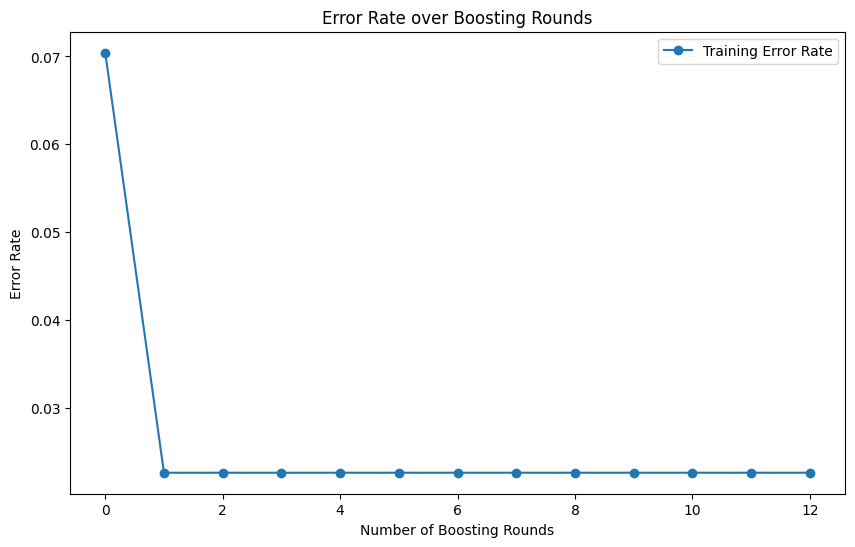

In [ ]:
# Plot error rates over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(range(len(ab.error_rates)), ab.error_rates, marker="o", label="Training Error Rate")
plt.xlabel("Number of Boosting Rounds")
plt.ylabel("Error Rate")
plt.title("Error Rate over Boosting Rounds")
plt.legend()
plt.show()

# Confusion Matrix

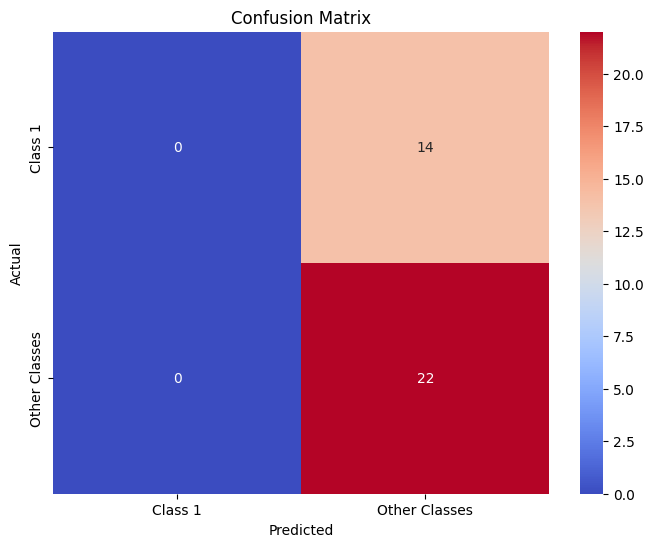

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Class 1", "Other Classes"], yticklabels=["Class 1", "Other Classes"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()